In [1]:
import numpy as np
import sys
import copy
import networkx as nx
from pyvis.network import Network
import plotly
import plotly.graph_objects as go
import math
from timeit import default_timer as timer
import time
from CodeModules.perm import *
import sympy as sp
import pickle


%matplotlib inline

In [3]:
#Settings:

QUIET = True #Just here so you can tell a function "QUIET" or "INVIS" and for some of these it will suppress part 
INVIS = False #of the output. For INVIS this will be graphical outputs
FORCE_VALID_GRIDS = False #Not fully implemented - may let some X and O be placed in the same square
FORCE_VALID_MOVES = False #Not fully implemented - prevents stabilizing where we can't and commuting columns illegally


In [4]:
import matplotlib.pyplot as plt  #code necessary for the grid diagram printing written by Evan Bell from SURIEM 2021 - saving here in case
import itertools                 #I decide to duplicate the functionality here
from scipy.optimize import curve_fit
from collections import defaultdict
import networkx as nx
from numba import jit
from numba import njit
%matplotlib inline

# Function to create a grid diagram given permutations of X and O positions
def display_grid(x_list, o_list):
    # Getting the size of the grid
    if len(x_list) == len(o_list):
        n = len(x_list)
    else:
        print('The length of the index lists do not match.')
    
    # Initializing figure and making gridlines
    plt.figure(figsize=(10*n/6,10*n/6))
    plt.vlines(range(2,n+1), ymin=1, ymax=n+1, zorder=8, color='gray', linewidth=3)
    plt.hlines(range(2,n+1), xmin=1, xmax=n+1, zorder=10.5, color='gray', linewidth=3)
    
    # Placing the X's and O's
    plt.scatter(np.arange(1, n+1)+0.5, np.array(x_list)+0.5, marker='x', s=1500, linewidth=5, c='black')
    plt.scatter(np.arange(1, n+1)+0.5, np.array(o_list)+0.5, marker='o', s=2000, linewidth=5, c='black')
    plt.scatter(np.arange(1, n+1)+0.5, np.array(o_list)+0.5, marker='o', s=1200, linewidth=5, c='white')

    # Drawing arrows
    for x, y, i in zip(x_list, o_list, range(1, n+1)):
        if x>y: # Downward pointing arrows
            plt.arrow(i+0.5, x+0.25, 0, y-x+.6, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=11)
            plt.arrow(i+0.5, x+0.25, 0, y-x+.6, width=0.15, head_width=0.2, color='white', length_includes_head=True, zorder=10)
        if x<y: # Upward pointing arrows
            plt.arrow(i+0.5, x+0.75, 0, y-x-0.6, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=11)
            plt.arrow(i+0.5, x+0.75, 0, y-x-0.6, width=0.15, head_width=0.2, color='white', length_includes_head=True, zorder=10)
        if o_list.index(i)<x_list.index(i): # Rightward pointing arrows
            plt.arrow(o_list.index(i)+1.85, i+0.5, x_list.index(i)-o_list.index(i)-0.55, 0, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=9)
        if o_list.index(i)>x_list.index(i): # Leftward pointing arrows
            plt.arrow(o_list.index(i)+1.15, i+0.5, x_list.index(i)-o_list.index(i)+0.55, 0, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=9)
    
    # Setting up the rest of the plot
    plt.xlim(1, n+1)
    plt.ylim(1, n+1)
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False) # https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
      

In [5]:
STAB_DIRS = ["NE","NW","SW","SE"]

class grid:      #Carries knot data - functions asking for a knot (unless otherwise specified)  
                 #are asking for a grid
        
    def __init__(self, given_x, given_o, check_grid_conditions = FORCE_VALID_GRIDS): #Loads grid information into the object and confirms the grid size is square
        check_if_valid(given_x)
        check_if_valid(given_o)
        self.sig_x = perm(given_x)
        self.sig_o = perm(given_o)
        self.size = perm(given_x).size()
        if self.size != perm(given_o).size():
            raise ValueError("Grid dimensions are not equal to eachother")
        if check_grid_conditions:
            for i in self.size:
                if self.sig_x.value[i] == self.sig_o.value[i]:
                    raise ValueError("Invalid grid - X and O appear in the same square")
                
    def __repr__(self, hide=INVIS):
        if not QUIET:
            print("sig_x: " + str(self.sig_x))
            print("sig_o: " + str(self.sig_o))
        if not hide:
            display_grid(self.sig_x.value, self.sig_o.value)
        return str([self.sig_x,self.sig_o])

    def show(self):
        display_grid(self.sig_x.value, self.sig_o.value)
        return
    
    def __str__(self):
        return (str(self.sig_x)+str(self.sig_o))
    
    def h_cycle(self, n = 1): #cycles the grid as a toroidal diagram horizontally n (negative to the left) times
        cycler = full_cycle(self.size)
        print(cycler)
        new_sig_x = self.sig_x*((cycler)**n)
        new_sig_o = self.sig_o*((cycler)**n)
        return grid(new_sig_x, new_sig_o)
    
    def v_cycle(self, n = 1): #cycles the grid as a toroidal diagram vertically n (negative down) times
        cycler = full_cycle(n)
        new_sig_x = ((cycler)**n)*self.sig_x
        new_sig_o = ((cycler)**n)*self.sig_o
        return grid(new_sig_x, new_sig_o)
        
    def x_stab(self, x_choice, direction = "NW"): #grid stabilization at an x - essentially splits that x into two rows and columns
                                                  #this makes for 4 (valid) ways to fill in the gaps, NW,NE,SE,SW
        h_switch = perm_from_cycle(((x_choice, x_choice+1),), self.size+1)
        v_switch = perm_from_cycle(((self.sig_x[x_choice],self.sig_x[(x_choice)]+1),), self.size+1)
        temp_sig_x = self.sig_x.widen_at(x_choice, self.sig_x[(x_choice)])
        temp_sig_o = self.sig_o.widen_at(x_choice, self.sig_x[(x_choice)])
        if direction == "NW":
            temp_sig_o = temp_sig_o*h_switch
            return grid(temp_sig_x,temp_sig_o)
        if direction == "NE":
            temp_sig_x = temp_sig_x*h_switch
            return grid(temp_sig_x,temp_sig_o)
        if direction == "SE":
            temp_sig_x = temp_sig_x
            temp_sig_o = v_switch*temp_sig_o
            return grid(temp_sig_x,temp_sig_o)
        if direction == "SW":
            temp_sig_x = temp_sig_x*h_switch
            temp_sig_o = v_switch*(temp_sig_o*h_switch)
            return grid(temp_sig_x,temp_sig_o)

    def x_destab(self, x_choice, check_if_legal = FORCE_VALID_MOVES): #still need to work out how to check for legality - ie see if the place
        height = self.sig_x[x_choice]                                 #we destabilize at is one of NE NW SE SW.
        x_temp = self.sig_x.collapse_at(x_choice)
        helper = perm_from_cycle(((height,self.sig_o[x_choice]),),self.size)
        o_temp = self.sig_o
        o_temp = (helper*o_temp).collapse_at(x_choice)
        return grid(x_temp, o_temp)

    def __hash__(self):
        identifier = ''
        for x in self.sig_x:
            identifier = identifier + str(x)
        for o in self.sig_o:
            identifier = identifier + str(o)
        return int(identifier)    
    
    
    def commute_columns(self, left_position, ValidGridMove = FORCE_VALID_MOVES):
        h_switch = perm_from_cycle(((left_position, left_position+1),), self.size)
        new_sig_x = self.sig_x*h_switch
        new_sig_o = self.sig_o*h_switch
        return grid(new_sig_x, new_sig_o)
        
    def __eq__(self, other):
        if type(other) != grid:
            return False
        if self.sig_x == other.sig_x:
            if self.sig_o == other.sig_o:
                return True
        return False

#END OF GRID TYPE DEFINITION    
    
    
def generate_all_grids(n):     #this is (as far as I can tell) tied to derangements, which is an NP-complete problem so this won't be
    perm_set = generate_sn(n)  #able to be incredibly optimized
    hold = []
    for element in perm_set:
        for other in perm_set:
            sudokurule = True
            for i in range(n):
                if element[i+1] == other[i+1]:
                    sudokurule = False
                    break
            if sudokurule:
                hold.append(grid(element,other))
    return hold



In [6]:
def symbol_coordinates(symbol_perm):
    
    if type(symbol_perm) == perm:
        
        temp = symbol_perm.value.copy()
        
    else:
        
        temp = symbol_perm.copy()
        
    for count, element in enumerate(temp):
        
        temp[count] = (count + 1.5, element + 0.5)
        
    return temp


def is_between(target, a, b):
    
    if target > a:
        if target < b:
            return True
    return False


def check_case_1(rect, target): #standard position rectangle to check rect[0] has both coordinates less
                                #than rect[1]
    if (is_between(target[0], rect[0][0], rect[1][0]) and is_between(target[1], rect[0][1], rect[1][1])):
        return True
    return False

def check_case_2(rect, target): #standard position rectangle to check rect[0] has both coordinates less
                                #than rect[1]
    if ((not is_between(target[0], rect[1][0], rect[0][0])) and is_between(target[1], rect[0][1], rect[1][1])):
        return True
    return False
    
def check_case_3(rect, target): #standard position rectangle to check rect[0] has both coordinates less
                                #than rect[1]
    if (is_between(target[0], rect[0][0], rect[1][0]) and (not is_between(target[1], rect[1][1], rect[0][1]))):
        return True
    return False

def check_case_4(rect, target): #standard position rectangle to check rect[0] has both coordinates less
                                #than rect[1]
    if ((not is_between(target[0], rect[1][0], rect[0][0])) and (not is_between(target[1], rect[1][1], rect[0][1]))):
        return True
    return False
    
def parent_check(rect, target):
    ax = rect[0][0]
    ay = rect[0][1]
    bx = rect[1][0]
    by = rect[1][1]
    if ( (ax < bx) and (ay < by) ):
        return check_case_1(rect, target)
    if ( (ax > bx) and (ay < by) ):
        return check_case_2(rect, target)
    if ( (ax < bx) and (ay > by) ):
        return check_case_3(rect, target)
    if ( (ax > bx) and (ay > by) ):
        return check_case_4(rect, target)
    print("invalid rectangle given")


        
        

In [7]:
def hv_set_shift(h,v,sigs): #shifts all permutations horizontally and vertically by h and v
    result = []
    if len(sigs) == 0:
        n = 0
    else:
        n = len(sigs[0])
    hshift = full_cycle(n)**(-h)
    vshift = full_cycle(n)**v
    for sig in sigs:
#        print(type(sig))
        result.append((vshift*sig)*hshift)
    return result

def truncated_sn(n, trunc_length): #for when you want the first "trunc_length" possibilities of s_n
    pre_result = generate_sn(n)    #This has room for optimization
    result = []
    for sig in pre_result:
        temp = sig.value.copy()
        trunc_sig = temp[0:trunc_length]
        if trunc_sig not in result:
            result.append(trunc_sig.copy())
    return result

def generate_all_states_outside_rectangle(rectangle, n): #rectangle given as lower left,upper right this function returns a list of states that 
#    print('rectangle given: ' + str(rectangle))
    r_width = (rectangle[1][0] - rectangle[0][0]) % n
#    print("r_width = " + str(r_width)) #debug line
    r_height = (rectangle[1][1] - rectangle[0][1]) % n
#    print("r_height = " + str(r_height)) #debug line
    if (r_width + r_height) > n:
        print("rectangle dimensions too large to have non-empty set of states")
        return []
    pre_result = []
    sa = truncated_sn(n-r_height-1, r_width - 1)    #region a is the one above the rectangle and b is the columns after that then s_a is the collection of intersection choices
#    print("populated sa as " +str(sa))  #for a grid state x that keeps the rectangle empty
    sb = generate_sn(n-abs(r_width)-1)  #sanity check: 2 intersections used by corners, rw - 1 for a and n - rw - 1 for b means 2 + a + b = n 
#    print("populated sb")
    if sa == []:
        whats_left = []
        for i in range(2,r_height+1):
            whats_left.append(i)
        for i in range(r_height+1,n+1):
            whats_left.append(i)
        for psi in sb:
            curr_state=[]
            curr_state.append(1)
            curr_state = [1+r_height] + curr_state
            for i in range(n-abs(r_width)-1):
                curr_state.append(whats_left[psi[i]-1])
            pcurr_state = perm(curr_state.copy())
#            print(pcurr_state)
            pre_result.append(pcurr_state)
    for sig in sa:
        x = sig.copy() #we're lifting this as a list rather than a permutation because we need to shift them all up by the height - making it no longer a perm
        for count, position in enumerate(x):
            x[count] = position + r_height + 1
#        print("x is " + str(x))
        whats_left = []
        for i in range(2,abs(r_height)+1):
            whats_left.append(i)
        for i in range(abs(r_height) + 2, n + 1):
            if i not in x:
                whats_left.append(i)
#        print("whats left is: " + str(whats_left))
        if sb == []:
            curr_state = x.copy()
            curr_state.append(1)
            curr_state = [1+r_height] + curr_state
            pcurr_state = perm(curr_state.copy())
            pre_result.append(pcurr_state)
        for psi in sb:
            curr_state=x.copy()
            curr_state.append(1)
            curr_state = [1+r_height] + curr_state
            for i in range(n-abs(r_width)-1):
                curr_state.append(whats_left[psi[i]-1])
            pcurr_state = perm(curr_state.copy())
#            print(pcurr_state)
            pre_result.append(pcurr_state)
#    print(str(pre_result))
    if not ((rectangle[0][0] == 1) and (rectangle[0][1] == 1)):
        raw_result = hv_set_shift(rectangle[0][0]-1, rectangle[0][1]-1, pre_result)
    else:
        raw_result = pre_result
    result = []
    rect_pairer = transposition(rectangle[0][0],rectangle[1][0],n)
    for sig in raw_result:
        result.append([sig*rect_pairer,sig])
    if result == []:
        return None
    return result

def generate_all_rectangle_sizes(n):
    result = []
    for width in range(1,n):
        for height in range(1,n+1-width):
            result.append((width,height))
    return result

def generate_all_rectangles(n):
    sizes = generate_all_rectangle_sizes(n)
    rects = []
    for size in sizes:
        for i in range(0,n):
            for j in range(0,n):
                x = (i % n + 1,j % n + 1)
                y = ((i+size[0]) % n + 1,(j+size[1]) % n + 1)
                rects.append((x,y))
#    print(rects)
    return rects

def zero_list(n):
    result = []
    for i in range(n):
        result.append(0)
    return result

def count_symbols(n, rect, symbol_perm):
    temp = zero_list(n)
    usable_sym = symbol_coordinates(symbol_perm)
    for i in range(n):
        if parent_check(rect, usable_sym[i]):
            temp[i] = 1
    return temp
        

def generate_all_edges(n, symbols): #n is the grid size and symbols are a collection of basepoints - in the case of a grid diagram this should be a list of two permutations
    pre_diff = generate_all_rectangles(n) #symbols is a list data type containing either lists or perms either should work
    symbol_count = len(symbols)
    place_holder = []
    z_list = zero_list(n)
    for i in range(symbol_count):
        place_holder.append(z_list.copy())
#    print('placeholder looks like: ' + str(place_holder))
    unweighted_diff = []
    for rect in pre_diff:
#        print('processing rectangle ' + str(rect))
        candidates = generate_all_states_outside_rectangle(rect, n)
        if candidates is not None:
            for count, candidate in enumerate(candidates):
                candidates[count] = [candidate.copy(), rect, place_holder.copy()]
            unweighted_diff = unweighted_diff + candidates
    for count, symbol in enumerate(symbols):
        for i in range(len(unweighted_diff)):
#            print(unweighted_diff)
            unweighted_diff[i][2][count] = count_symbols(n, unweighted_diff[i][1], symbol) #after this it should be weighted
    return unweighted_diff

In [26]:
def pickle_it(comp, filename):
    
    file = open(filename, 'wb')
    pickle.dump(comp, file)
    file.close()
    
    return

def pickle_cinf(gknot, filename = 'DefaultPickleComp'):
    
    if filename == 'DefaultPickleComp':
        print('No name provided for pickling - saving to DefaultPickleComp')
    size = gknot.size
    comp = generate_all_edges(size, [list(gknot.sig_x),list(gknot.sig_o)])
    g = nx.DiGraph()
    for ele in comp:
        
        g.add_edge(str(ele[0][0]),str(ele[0][1]), diffweight = (ele[2][0] + ele[2][1]))
        # print(g.edges()[str(ele[0][0]),str(ele[0][1])])
        
    pickle_it((g, size), filename)
    
    return

In [27]:
#naming some common knots
trefoil = grid([5, 1, 2, 3, 4], [2, 3, 4, 5, 1])
unknot = grid([1,2],[2,1])
figureEight = grid([5,4,1,6,2,3],[2,6,5,3,4,1])
conway = grid([1,2,4,8,5,7,6,10,3,9,11],[4,5,10,3,1,11,9,8,7,2,6])


In [31]:
pickle_cinf(figureEight)

No name provided for pickling - saving to DefaultPickleComp


In [20]:
generate_all_rectangle_sizes(5)

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 1),
 (3, 2),
 (4, 1)]

In [31]:
#generate_all_rectangles(3)

In [32]:
#trefoil.h_cycle()

In [21]:
generate_all_states_outside_rectangle(((1,1),(3,3)),5)

[[[1, 5, 3, 2, 4], [3, 5, 1, 2, 4]],
 [[1, 5, 3, 4, 2], [3, 5, 1, 4, 2]],
 [[1, 4, 3, 2, 5], [3, 4, 1, 2, 5]],
 [[1, 4, 3, 5, 2], [3, 4, 1, 5, 2]]]

[[1, 2, 3, 4, 5], [2, 3, 4, 5, 1]]

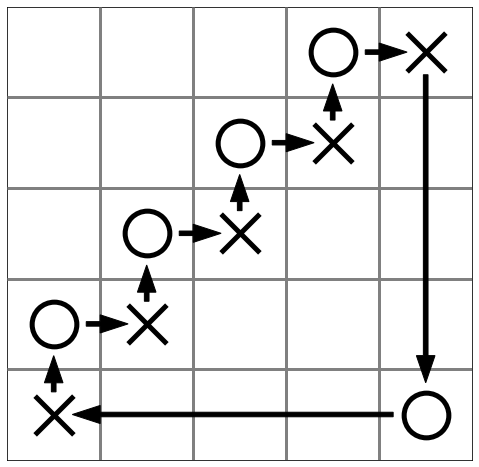

In [8]:
grid([1, 2, 3, 4, 5], [2, 3, 4, 5, 1])

In [10]:
comp = generate_all_edges(6,[[5,4,1,6,2,3],[2,6,5,3,4,1]])
# print(comp)
g = nx.DiGraph()
for ele in comp:
    g.add_edge(str(ele[0][0]),str(ele[0][1]),weight = str(ele[2]))
nx.write_gml(g, 'Figure8.gml')

In [20]:
#trying to avoid conversion to strings to speed up the process

comp = generate_all_edges(6,[[5,4,1,6,2,3],[2,6,5,3,4,1]])
# print(comp)
g = nx.DiGraph()
for ele in comp:
    g.add_edge(str(ele[0][0]),str(ele[0][1]),weight = (ele[2]))
# nx.write_gml(g, 'Figure8.gml')
pickle_it((g, ), 'testingpicknew')

In [23]:
trefoil.sig_o

[2, 3, 4, 5, 1]

In [30]:
pickle_cinf(trefoil, 'trefoilpickle')

In [9]:
# Amat = nx.to_dict_of_dicts(g)
# matKeys = list(Amat.keys())
# Amat['[1, 2, 3]']
# i = 0
# for gener in matKeys:
#     Amat[gener]['index']=i
#     i += 1
# Amat

In [36]:
# Amat[matKeys[0]]

In [23]:
U, V = sp.symbols('U V')
F = sp.FF(2)[U,V,(U**-1)]
#F((1) + (U+U)+ (U*U*(U**-1)*(U**-1)*(U**-1)*(U**-1)))
p = F((U**1)*(U**1)*(U**1)+U*V+V+U*V**2)
print(p)
dict(p)

U**3 + U*V**2 + U*V + V


{(0, 1, 0): SymmetricModularIntegerMod2(1),
 (3, 0, 0): SymmetricModularIntegerMod2(1),
 (1, 1, 0): SymmetricModularIntegerMod2(1),
 (1, 2, 0): SymmetricModularIntegerMod2(1)}

In [ ]:
for thing in Amat:
    c

In [ ]:
generate_all_edges(5,[[5, 1, 2, 3, 4], [2, 3, 4, 5, 1]])

In [22]:
type(comp[0][0][0])

CodeModules.perm.perm

[[5, 1, 2, 3, 4], [2, 3, 4, 5, 1]]

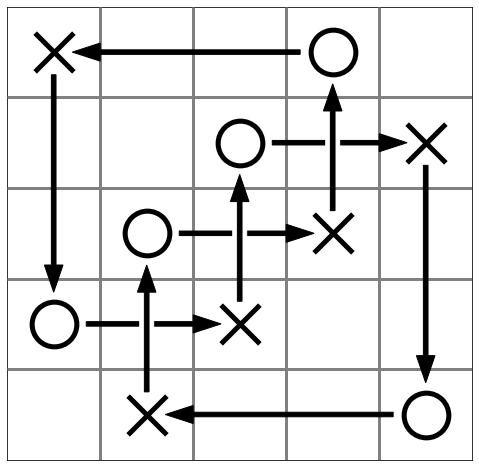

In [12]:
trefoil

In [ ]:
# G = Grid_Chain_Complex(trefoil)
# nx.write_gml(G, "demoGCC.gml")

In [ ]:
def stDiff(givenGrid):
    diff = {}
    for x in range(1, givenGrid.size + 1):
        current = givenGrid.x_destab(x)
        if current in diff:
            diff[current] += 1
        else:
            diff[current] = 1
            print(current.sig_x)
            print(current.sig_o)
            display_grid(current.sig_x.value, current.sig_o.value)
    return diff

def addToGraphFromDictZ2(source, data, G):
    for target in data:
        if data[target]%2 == 1:
            G.add_edge(str(source), str(target))
    return

def stComplex(givenGrid):
    G = nx.DiGraph()
    currentSize = givenGrid.size
    curBasis = [givenGrid]
    for count in range(currentSize - 1):
        nextBasis = []
        for obj in curBasis:
            curDiff = stDiff(obj)
            addToGraphFromDictZ2(obj, curDiff, G)
            for dx in curDiff:
                print("dx is " + str(dx))
                if dx not in nextBasis:
                    nextBasis.append(dx)
        curBasis = nextBasis
    return G

In [ ]:
for x in range(5):
    G = stComplex(trefoil.h_cycle(x+1))
    adMat = nx.adjacency_matrix(G)
    
    nx.write_gml(G, "stDiffTrefoil" + str(x) + ".gml")

In [ ]:
g = nx.Graph()

In [ ]:
x, y = sp.symbols('x y')

In [ ]:
type(x)

In [ ]:
np.array([[1,2],[0,1]])

In [ ]:
np.dtype(np.array([1,2]))

In [ ]:
ar = np.array([1,2],subok = False)
# dt = np.dtype([('x', 'i8', (1,2))])
# ar = ar.astype(dt)
ar

In [ ]:
g = nx.Graph()
g.add_edge('a','b',weight = ar)

In [ ]:
nx.to_numpy_matrix(g, dtype = dt)

In [96]:
M = sp.Matrix([[3,2,2],[1,U,3]])  

In [102]:
M[1,0] = V**2

In [103]:
M

Matrix([
[   3, 2, 2],
[V**2, U, 3]])